# Homework 2

## Markets

### UChicago Financial Mathematics

#### September 2024

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

# Data

Use the data file `../data/treasury_quotes_<DATE>.xlsx`.
* replace `<DATE>` with `2024-05-31`
* consider this the date at the time of valuation.

In [52]:
# PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [53]:
date = '2024-05-31'
treasury_quotes = pd.read_excel(f'../data/treasury_quotes_{date}.xlsx', sheet_name='quotes')

***

# 1. Treasury Debt Composition

### Data
Use the data in the `quotes` tab.

## 1.1
Plot the total amount of outstanding debt maturing at each date

* Do this for `total size`, as that is listed for T-bills.
* (You could also examine `public size`, but that will exclude T-bills.)

Tip: `.pivot_table()` may be useful.

<Axes: title={'center': 'Total Treasury Debt'}, xlabel='Maturity', ylabel='$'>

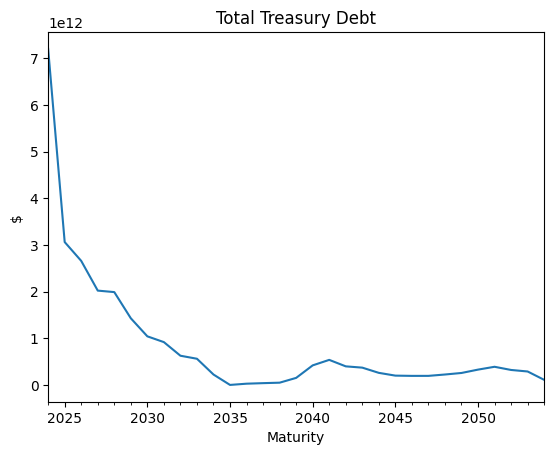

In [54]:
# Clean the data
debts = treasury_quotes.pivot_table(values= 'total size', index='maturity date', columns= 'type', aggfunc='sum').resample('YE').sum()
debts['TIPS'] = debts['TIPS bond'] + debts['TIPS note']

debts.drop(columns=['TIPS bond', 'TIPS note'], inplace=True)

debts.sum(axis=1).plot(title='Total Treasury Debt', ylabel='$', xlabel='Maturity')


## 1.2
Plot the amount of outstanding debt maturing at each date, segmented by bonds, notes, TIPS.


<Axes: title={'center': 'Treasury Debt by Type'}, xlabel='Maturity', ylabel='$'>

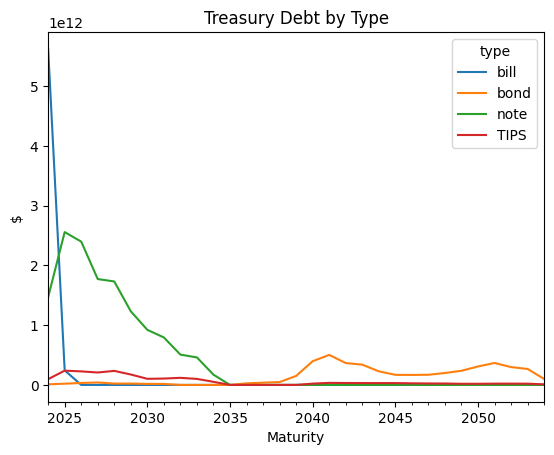

In [55]:
# Plot the debt by type
debts.plot(title='Treasury Debt by Type', ylabel='$', xlabel='Maturity')

## 1.3
Report the total outstanding debt (summed over all maturity dates,) segmented by bonds, notes, TIPS.

In [56]:
debts.sum()

type
bill    5,866,778,000,000
bond    4,560,331,000,000
note   14,013,743,000,000
TIPS    2,025,754,000,000
dtype: float64


## 1.4
Make a pie chart of this total number (reported in 1.3.) 

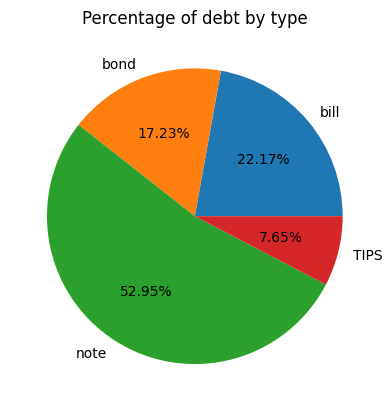

In [57]:
plt.pie(debts.sum().values, labels=debts.columns, autopct='%1.2f%%')

plt.title('Percentage of debt by type')
plt.show()

## 1.5

Calculate the time-to-maturity (relative to the quoted date) for each issue.

Report the summary statistics of these time-to-maturities. 

Consider using `.describe()`

In [58]:
treasury_quotes.groupby('type')['ttm'].describe()


,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
TIPS bond,30,4,3,0,2,4,6,10
TIPS note,23,16,10,1,5,19,24,30
bill,51,0,0,0,0,0,0,1
bond,99,18,8,0,16,19,24,30
note,243,3,2,0,1,2,4,10


***

# 2 YTM and Price

The problems in this section ask you to calculate the **yield-to-maturity (YTM)** of various bonds.

You will need to use a nonlinear solver to solve for the YTM.

For any given bond, YTM ($y$) solves...

$$p = \sum_{i=1}^{2n}\frac{Fc/2}{(1+y/2)^i} + \frac{F}{(1+y/2)^{2n}}$$

where
* $p$ is the bond's price.
* $n$ is the number of years to maturity
* $c$ is the coupon rate (a percentage)
* $F$ is the face value. Use $F=100$

#### Solving for YTM
Consider using `fsolve` to solve the yield implicitly from the nonlinear equation. This function is imported with...

`from scipy.optimize import fsolve`

## 2.1

Consider a semiannual bond with the following stylized parameters:
* time-to-maturity of 30 years
* coupon rate: 3%
* Face value of 100

1. Assume the YTM is 5%. Calculate the price.
1. Assume the price is 87. Calculate the YTM.

In [81]:
# Parameters
ttm = 30
coupon = 0.03
face_value = 100

# First calculation
ytm = 0.05
# Calculate the price
price = np.sum((face_value*coupon/2)/(1+ytm/2)**np.arange(1, 2*ttm+1)) + face_value/(1+ytm/2)**(2*ttm)
print(price)



69.09134351494268


In [82]:
from scipy.optimize import fsolve

# Second calculation
price = 87

# Solve for YTM

def calculate_price(ytm):
    return np.sum((face_value*coupon/2)/(1+ytm/2)**np.arange(1, 2*ttm+1)) + face_value/(1+ytm/2)**(2*ttm)

def calculate_ytm(price):
    return fsolve(lambda ytm: calculate_price(ytm) - price, 0.05)[0]

ytm = calculate_ytm(price)
print(ytm)


0.03723106689116996


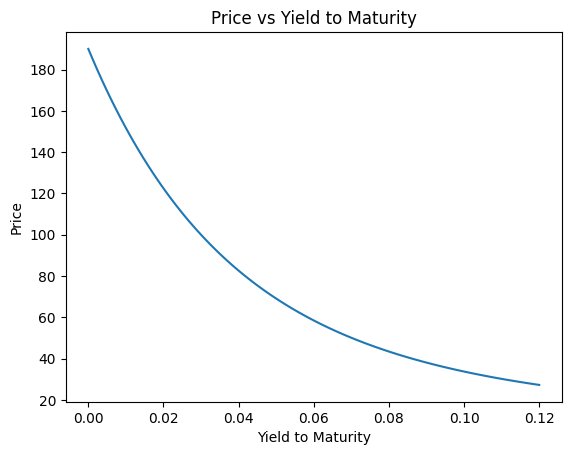

In [97]:
# Lets do an extra example: Why don't we calculate it for different prices and values of ttm. And then plot it
ytm_vector = np.linspace(0, 0.12, 100)
price_vector = np.zeros_like(ytm_vector)

for i, ytm in enumerate(ytm_vector):
    price_vector[i] = calculate_price(ytm)

plt.plot(ytm_vector, price_vector)
plt.xlabel('Yield to Maturity')
plt.ylabel('Price')
plt.title('Price vs Yield to Maturity')
plt.show()


## 2.2

### Data
Use the data in the `selected quotes` tab.
* It gives treasury bond data for various maturities, spaced roughly six months apart.
* Feel free to approximate the time-to-maturity to be exactly semiannually if that is easier for the problem below.
* Use the `price` column for the price data in the YTM formula. (No need to worry about "dirty" price, bid, ask, nor accrued interest.)

1. Calculate the yield-to-maturity for each issue. How close are your calculations to the provided column `ytm`?

1. Plot the time-to-maturity (TTM) against the calculated YTM.

***

In [115]:
# PACKAGES
from scipy.optimize import fsolve

# Define the function to calculate the bond price given the YTM
def bond_price(ytm, face_value, coupon_rate, ttm, freq=2):
    coupon = coupon_rate * face_value / freq
    periods = int(ttm * freq)
    discount_factors = [(1 + ytm / freq) ** -(i + 1) for i in range(periods)]
    price = sum([coupon * df for df in discount_factors]) + face_value * discount_factors[-1]
    return price

# Define the function to calculate YTM
def ytm(price, ttm, coupon_rate, face_value=100, x0=0.02, freq=2):
    func = lambda y: bond_price(y, face_value, coupon_rate, ttm, freq) - price
    return fsolve(func, x0)[0]


<Axes: xlabel='ttm'>

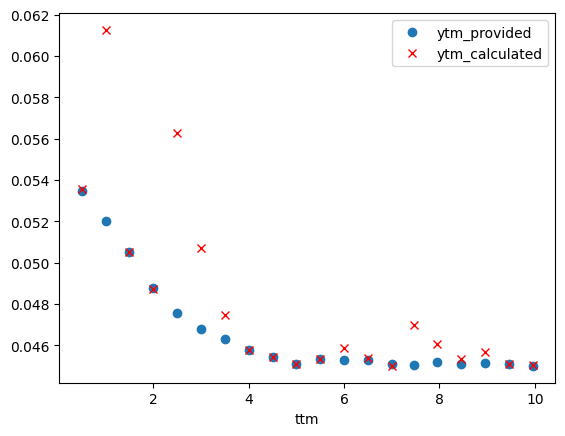

In [117]:
date = '2024-05-31'
selected_quotes = pd.read_excel(f'../data/treasury_quotes_{date}.xlsx', sheet_name='selected quotes')

yield_curve = pd.DataFrame(index=selected_quotes.index, columns=['ttm', 'ytm_provided', 'ytm_calculated'])

# Calculate YTM for each bond
for i in selected_quotes.index:
    yield_curve.loc[i, 'ytm_calculated'] = ytm(
        selected_quotes.loc[i, 'price'], 
        selected_quotes.loc[i, 'ttm'], 
        selected_quotes.loc[i, 'cpn rate'] / 100, 
        x0=0.02
    )

# Fill in the 'ttm' and 'ytm_provided' columns
yield_curve['ttm'] = selected_quotes['ttm']
yield_curve['ytm_provided'] = selected_quotes['ytm']

# Display the yield curve
yield_curve.plot(x='ttm', y=['ytm_provided', 'ytm_calculated'], style=['o', 'rx'])

# 3. Extra

If you would like to go further with computing yields, try these problems.

### Data
Use the data in the `selected quotes` tab.

Focus on the nominal securities. 
* Exclude any row with `type` of `TIPS note` or `TIPS bond`.

## 3.1
Plot the time-to-maturity against the provided YTM.

## 3.2

1. Calculate the YTM of each (nominal) bond issue in the data set. 

1. Report how far your YTM calculation is from those reported in the data set.

1. Report your calculated YTM for the issues where the dataset does not provide a YTM.


## 3.3

For the Treasury bills, calculate the **discount yields**.

Identify the T-bills using `type`=`bill` or looking for `cpnrate` of 0.

***